<a href="https://colab.research.google.com/github/mastroiannioliveira/dataset/blob/master/Fad_Trab02_MastroianniOliveira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- IMPORTS

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# 2 - PREPARANDO DATASET

## 2.1 - Dataset Air Quality

In [ ]:
data = pd.read_csv("AirQualityUCI.csv", sep=';')

#EMBARALHA DATASET
data = data.sample(frac=1).reset_index(drop=True)
data['Date'] = data['Date'].astype('datetime64[ns]')
data['Date'] = data['Date'].values.astype(float)

y = data['NOx(GT)'].values

del data['NOx(GT)']
# del data['Date']
# del data['Time']

print('Número de amostras:\t\t{}'.format(len(data)))
print('Número de características:\t{}'.format(data.shape[1]))
print('Outputs:\t\t\t{}'.format(len(y)))
data.head()

Número de amostras:		9357
Número de características:	14
Outputs:			9357


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1.098576e+18,19,5.2,1555,-200,24.3,1410,464,127,1971,2185,21.7,62.9,1.6117
1,1.109549e+18,16,0.9,799,-200,2.5,617,1099,114,699,382,3.3,33.1,0.2592
2,1.097539e+18,13,1.8,920,-200,8.1,903,849,114,1011,853,18.1,21.3,0.4396
3,1.081123e+18,15,2.6,1197,-200,12.9,1082,753,97,1851,971,19.9,57.1,1.3158
4,1.098662e+18,14,3.8,1454,-200,23.1,1380,457,117,1947,1672,21.5,60.9,1.5398


# 3 - BIBLIOTECA FUNÇÕES

## 3.1 - Funções para exemplo aula

In [ ]:
# acrescenta uma coluna de 1s no final de uma matriz
def add_ones_column(M):
    return np.column_stack((M, np.ones(np.shape(M)[0])))

# constroi e resolve a equação normal A^T A x = A^T b
def solve_normal_eqn(M,v):
    return np.linalg.solve(np.matmul(np.transpose(M),M),\
                          np.matmul(np.transpose(M), v))

# constroi os gráficos dos resultados, comparando a
# saída real com a saída estimada. Calcula, ainda, o erro
def scatter_results(true_y, predicted_y):
    #Scatter-plot the predicted vs real
    #Plots:
    #   * real(x) vs predicted(y)
    #   * perfect agreement line
    #Returns the root mean square of the error

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(true_y, predicted_y, '.b')
    
    min_limit = min(np.amin(true_y),np.amin(predicted_y))
    max_limit = max(np.amax(true_y),np.amax(predicted_y))
    ax.plot([min_limit, max_limit], [min_limit, max_limit], '--k')
    
    
    #rms = (true_y - predicted_y).std()
#     rmse = np.sqrt(np.mean((true_y - predicted_y)**2))
    rmse = sqrt(mean_squared_error(true_y, predicted_y))
    
    ax.text(0.99*max_limit, 1.01*min_limit,'Root Mean Square Error = %.2f' % rmse,
            ha='right', va='bottom')

    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    
    ax.set_xlabel('Valores reais')
    ax.set_ylabel('Valores estimados')
    
    return rmse

## 3.2 - Funções Stoppiglia

### 3.2.1 - Funções para passos Stoppiglia

In [ ]:
def cosine_sqr(X, y):
    numerator = (X.dot(y) ** 2)
    denominator = np.apply_along_axis(lambda x: x.dot(x), 1, X) * y.dot(y)
    denominator[np.where(denominator == 0)] = 1e-9

    cos_sqr_Xy = numerator / denominator

    return cos_sqr_Xy


def project_on_nullspace(feature_matrix, nullspace):
    nullspace_tr = nullspace.transpose()

    return np.dot(
        np.dot(nullspace, np.linalg.inv(np.dot(nullspace_tr, nullspace))),
        np.dot(nullspace_tr, feature_matrix.transpose())).transpose()


def _fac_term_odd(k):
    numerator = np.arange(2 * k - 1, 0, -2)
    twos = np.ones(k) * 2
    denominator = np.arange(k, 0, -1)
    denominator = twos * denominator
    q = (numerator / denominator)

    return np.prod(q)


def _fac_term_even(k):
    twos = np.ones(k) * 2
    numerator = np.arange(k, 0, -1)
    numerator = twos * numerator
    denominator = np.arange(2 * k + 1, 0, -2)

    numerator = np.append(numerator, 1)

    q = (numerator / denominator)

    return np.prod(q)


def CDF(cosine_sqr, space_dimension):
    x = cosine_sqr
    v = space_dimension

    if v >= 2:
        # Proceed
        if v % 2 == 0:
            # CDF for even stage
            Phi = lambda x, v: (1 + sum([(
                    _fac_term_even(k) * (1 - x) ** k) for k in range(
                1,
                int(v / 2 - 2) + 1)])) if v >= 6 else (1 if v == 4 else 0)

            Pv_x = lambda x, v: (2 / np.pi) * (np.arcsin(x ** 0.5) + (x * (
                    1 - x)) ** 0.5 * Phi(x, v))
        else:
            # CDF for odd

            Phi = lambda x, v: (1 + sum([(
                    _fac_term_odd(k) * (1 - x) ** k) for k in range(
                1,
                int((v - 3) / 2) + 1)])) if v >= 5 else 1

            Pv_x = lambda x, v: (x) ** 0.5 * Phi(x, v)

        return Pv_x(x, v)

    else:
        raise ('stage must be greater than or equal to 2')

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg as la
import os

def rank_features(feature_df, target, risk=1):
    X = np.array(feature_df)
    y = target.copy()

    features = np.array(feature_df.columns)
    real_feature_indices = np.arange(features.shape[0])

    # Initialise varibales
    ranked_features = [
    ]  # This will hold list of feature names sorted by their ranks

    selected_features = np.array(
        [], dtype=int
    )  # This will hold the list of indices or features as in real_feature_indices sorted by ranks

    # For the first feature selection

    feature_selection_risk = {
        # Mapping for probability relevancy for a feature when compared with previously selected features
    }

    X_tr = X.transpose()

    n_features, n_instances = X_tr.shape[0], X_tr.shape[1]

    cos_sqr_xy = cosine_sqr(X_tr, y)

    feature_with_least_angle = np.where(cos_sqr_xy == np.max(cos_sqr_xy))[0][0]
    selected_features = np.append(selected_features, feature_with_least_angle)
    ranked_features.append(features[feature_with_least_angle])
    refined_features = np.delete(features, selected_features)
    real_feature_indices = real_feature_indices[
        ~np.isin(real_feature_indices, selected_features)]
    feature_selection_risk[0] = 0
    
    with tqdm(total= n_features - 1, desc='TOTAL') as pbar:
        for i in range(n_features - 1):
            x_least = sp.matrix(X_tr[selected_features])

            rowmask = np.zeros(X_tr.shape[0]).astype(int)
            rowmask[selected_features] = 1
            xmask = np.repeat(rowmask, n_instances).reshape(-1, n_instances)

            X_tr_masked = np.ma.MaskedArray(X_tr, xmask)
            X_rem_features = X_tr_masked.compressed().reshape(
                -1, n_instances)  # Matrix of remaining feature vectors

            # Finding null space of selected features
            x_least_null_space = la.null_space(x_least,
                                                      n_features - (i + 1))

            # Projecting remaining features onto nullspace of selected features
            X_rem_features_projected = project_on_nullspace(
                X_rem_features, x_least_null_space)

            # Projecting target onto nullspace of selected features
            y_proj = project_on_nullspace(y, x_least_null_space)

            # Calculation of cosine**2 for each feature with target vector
            cos_sqr_xy = cosine_sqr(X_rem_features_projected, y_proj)

            feature_with_least_angle = real_feature_indices[np.where(cos_sqr_xy == np.max(cos_sqr_xy))][0]

            selected_features = np.append(selected_features,
                                          feature_with_least_angle)

            real_feature_indices = real_feature_indices[
                ~np.isin(real_feature_indices, selected_features)]

            ranked_features.append(features[feature_with_least_angle])
            refined_features = np.delete(features, selected_features)

            space_dimension = x_least_null_space.shape[1] - (i + 1)
            cdf = round(CDF(np.max(cos_sqr_xy), space_dimension), 6)

            Pv = 1 - cdf
            feature_selection_risk[
                i + 1] = feature_selection_risk[i] + Pv * (
                    1 - feature_selection_risk[i])
            
            if feature_selection_risk[i + 1] > risk:
                break
                
            pbar.update(1)
            

    return {'ranked_features': ranked_features, 'feature_selection_risk': feature_selection_risk}

# 4 - EXPERIMENTOS


## 4.1 - Air Quality

### 4.1.1 - Separa os conjuntos de treino e teste


In [ ]:
X = data.values.astype(np.float)
X.shape

(9357, 14)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

### 4.1.2 - Regressão Linear via mínimos quadrados

Coeficientes da regressão:
 [ 4.24049403e-33 -4.29868752e-01  3.32705676e-01  2.25229603e-04
 -9.04340935e-05 -2.35826279e-01  1.69898225e-03  4.05293746e-05
  5.48476775e-04 -2.04873517e-04  9.18820521e-05 -8.56008058e-02
  1.21951508e-02  4.28009628e-01 -9.52479804e-15  8.90695456e+00
  6.61716212e+01 -5.65404134e-01 -1.43646187e-01 -8.80090984e+01
 -4.76305081e-01 -7.27336732e-02  1.25058505e+00  3.03030423e-01
 -1.83636369e-01  5.95339630e-02 -2.52629478e-01  1.13685604e+02
  5.36489958e+03]


Text(0.5, 1.0, 'Conjunto de Teste')

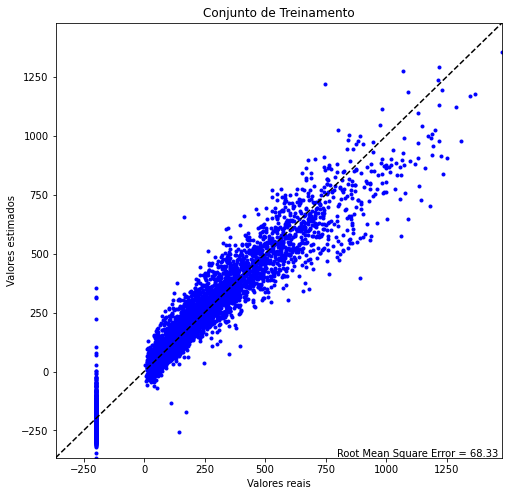

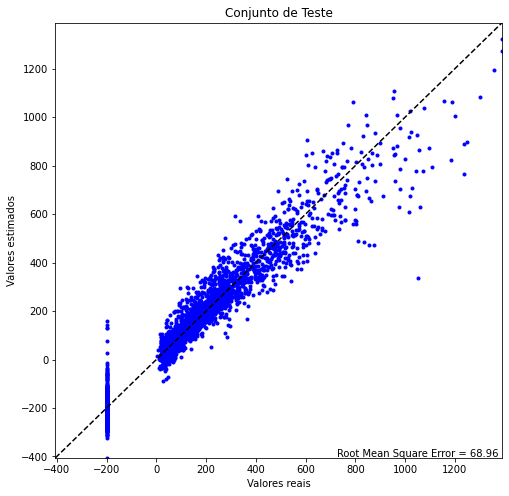

In [ ]:
aux_train = add_ones_column(np.column_stack((np.square(X_train),X_train)))
aux_test = add_ones_column(np.column_stack((np.square(X_test),X_test)))

Q, R = np.linalg.qr(aux_train)

coef_regression = np.linalg.solve(R, np.matmul(np.transpose(Q), y_train))

print('Coeficientes da regressão:\n', coef_regression)

# com o coeficiente linear
predicted_y_train = np.matmul(aux_train, coef_regression)
predicted_y_test = np.matmul(aux_test, coef_regression)

scatter_results(y_train, predicted_y_train)
plt.title('Conjunto de Treinamento')
scatter_results(y_test, predicted_y_test)
plt.title('Conjunto de Teste')

### 4.1.3 - Stoppiglia para ranqueamento


In [ ]:
data = data.iloc[:2000]
y = y[:2000]
X = data.values.astype(np.float)

In [ ]:
rank_caracteristicas_stoppiglia = rank_features(data, y, risk=1)
ranked_features = rank_caracteristicas_stoppiglia['ranked_features']
print(rank_caracteristicas_stoppiglia['ranked_features'])


['NO2(GT)', 'PT08.S5(O3)', 'PT08.S2(NMHC)', 'PT08.S1(CO)', 'Time', 'Date', 'PT08.S4(NO2)', 'NMHC(GT)', 'PT08.S3(NOx)', 'RH', 'AH', 'CO(GT)', 'T', 'C6H6(GT)']


### 4.1.4 - RMSE por características principais

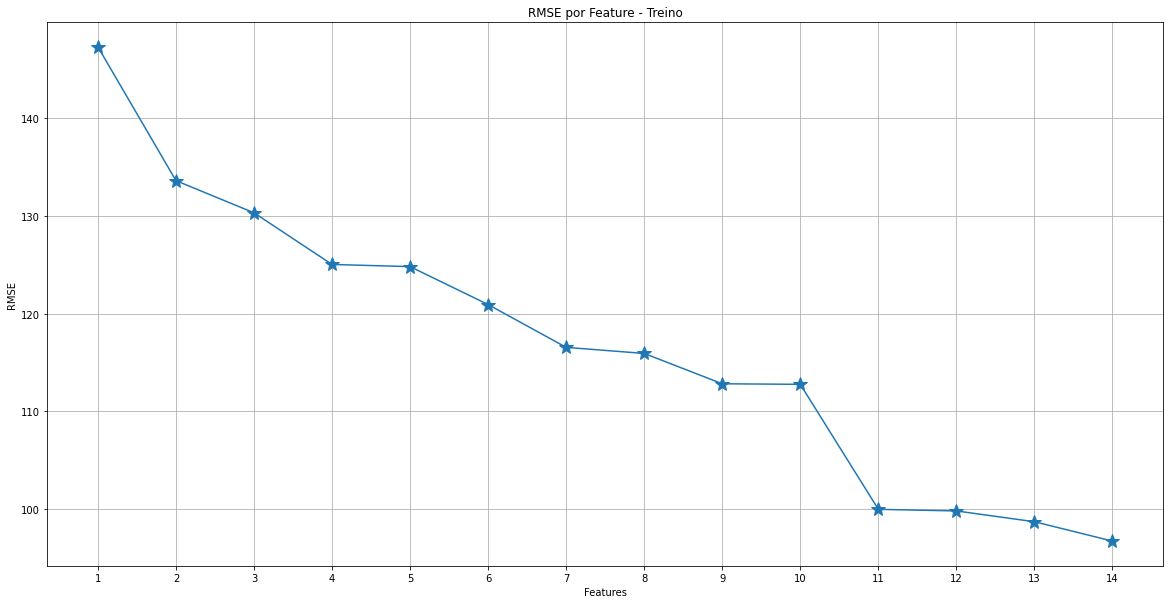

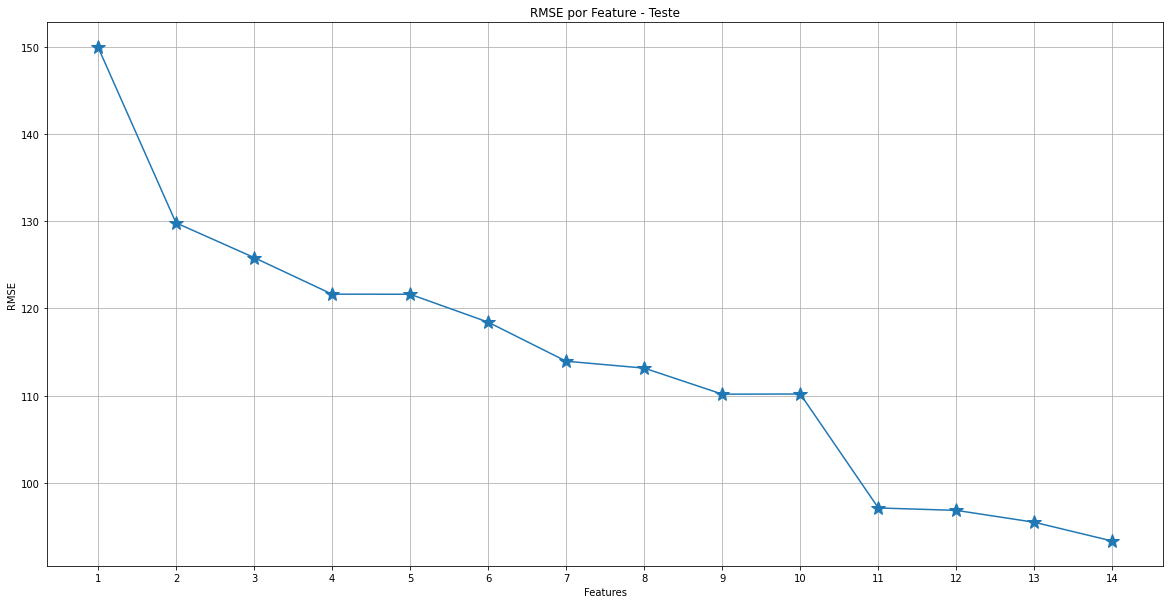

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt


feature = []
rmse_test = []
rmse_train = []

with tqdm(total= len(ranked_features), desc='TOTAL') as pbar:
    for ranked_feature in ranked_features:
        feature.append(ranked_feature)

        X = data[feature].values.astype(np.float)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

        # sem o coeficiente linear (somente para comparar com a regressão do sklearn)
        #Q, R = np.linalg.qr(X_train)
        # com o coeficiente linear
        Q, R = np.linalg.qr(add_ones_column(X_train))

        coef_regression = np.linalg.solve(R, np.matmul(np.transpose(Q), y_train))

    #     print('Coeficientes da regressão:\n', coef_regression)

        # com o coeficiente linear
        predicted_y_test = np.matmul(add_ones_column(X_test), coef_regression)
        predicted_y_train = np.matmul(add_ones_column(X_train), coef_regression)

        rmse_test.append(sqrt(mean_squared_error(y_test, predicted_y_test)))
        rmse_train.append(sqrt(mean_squared_error(y_train, predicted_y_train)))

    #     scatter_results(y_train, predicted_y_train)
    #     plt.title('Conjunto de Treinamento')

    #     scatter_results(y_test, predicted_y_test)
    #     plt.title('Conjunto de Teste')
        pbar.update(1)


    fig = plt.figure(num=1, figsize=(20,10))
    plt.title('RMSE por Feature - Treino')
    plt.plot(range(1,len(ranked_features)+1), rmse_train, '-*', markersize=15)
    plt.grid(True)
    plt.xticks(range(1,len(ranked_features)+1))
#     plt.yticks(rmse_train)
    plt.xlabel('Features')
    plt.ylabel('RMSE')
    plt.show()
    plt.close()
    
    fig = plt.figure(num=2, figsize=(20,10))
    plt.title('RMSE por Feature - Teste')
    plt.plot(range(1,len(ranked_features)+1), rmse_test, '-*', markersize=15)
    plt.grid(True)
    plt.xticks(range(1,len(ranked_features)+1))
#     plt.yticks(rmse_test)
    plt.xlabel('Features')
    plt.ylabel('RMSE')
    plt.show()
    plt.close()
    
    df_rmse_train = pd.DataFrame(rmse_train)
    df_rmse_test = pd.DataFrame(rmse_test)

### 4.1.5 - Regressão com redução de caracterśiticas

In [ ]:
X = data[ranked_features[0:11]].values.astype(np.float)
X.shape

(9357, 11)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Coeficientes da regressão:
 [ 2.37280872e-03  8.89931187e-05  1.31220797e-04  4.70882766e-04
 -3.67754270e-01 -5.92396454e-33 -2.19953683e-04 -4.49473387e-05
  1.02606613e-05 -2.19724660e-02  4.43574182e-01  1.60052951e+00
 -2.07924914e-01  3.68179120e-01 -1.08933827e+00  7.86813358e+00
  1.23913638e-14  3.05772911e-01 -1.05100583e-01  2.04910958e-02
  5.01928287e+00  7.96289087e+01 -6.48241419e+03]


Text(0.5, 1.0, 'Conjunto de Teste')

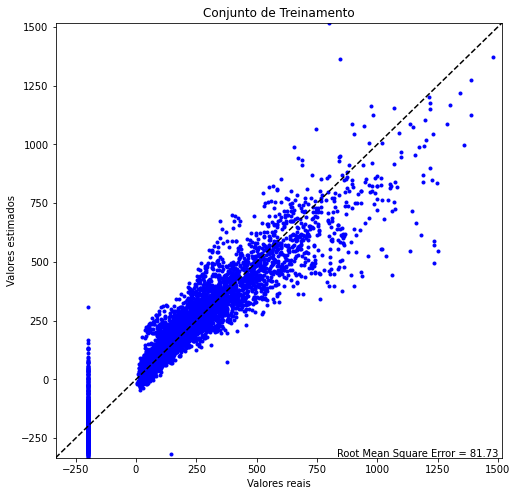

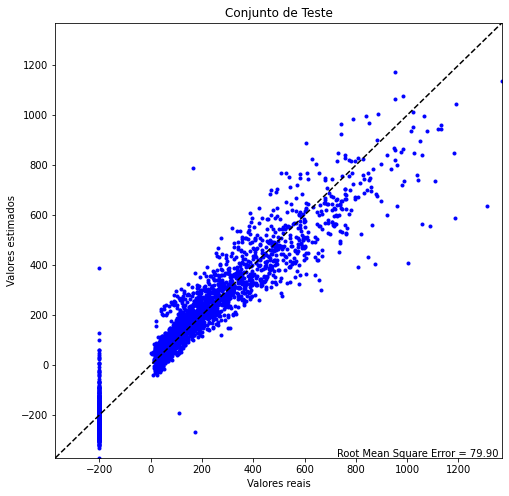

In [ ]:
aux_train = add_ones_column(np.column_stack((np.square(X_train),X_train)))
aux_test = add_ones_column(np.column_stack((np.square(X_test),X_test)))

Q, R = np.linalg.qr(aux_train)

coef_regression = np.linalg.solve(R, np.matmul(np.transpose(Q), y_train))

print('Coeficientes da regressão:\n', coef_regression)

# com o coeficiente linear
predicted_y_train = np.matmul(aux_train, coef_regression)
predicted_y_test = np.matmul(aux_test, coef_regression)

scatter_results(y_train, predicted_y_train)
plt.title('Conjunto de Treinamento')
scatter_results(y_test, predicted_y_test)
plt.title('Conjunto de Teste')